<a href="https://colab.research.google.com/github/georgiivarygin/weapon_detection_ISS_HACK/blob/main/iss_hack_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт необходимых библиотек

In [1]:
import cv2
import matplotlib.pyplot as plt

import glob
import os
import shutil

from tqdm.notebook import tqdm

from moviepy.editor import * 
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2129920/45929032 bytes (4.6%)3629056/45929032 bytes (7.9%)6012928/45929032 bytes (13.1%)8732672/45929032 bytes (19.0%)10641408/45929032 bytes (23.2%)12886016/45929032 bytes (28.1%)15335424/45929032 bytes (33.4%)18227200/45929032 bytes (39.7%)20013056/45929032 bytes (43.6%)21995520/45929032 bytes (47.9%)24829952/45929032 bytes (54.1%)27729920/45929032 bytes (60.4%)304

In [3]:
# Библиотека для отслеживания обучения сети
!pip install wandb

     |████████████████████████████████| 1.7 MB 6.8 MB/s 
     |████████████████████████████████| 144 kB 53.8 MB/s 
     |████████████████████████████████| 180 kB 44.9 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=99276e1100cffd2d9301b5ef057a09deec27d8fe5757a7430dc5d8da962444e8
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


# Клонируем репозиторий с yolov5 и устанавливаем требуемые библиотеки

In [ ]:
%cd /content/drive/MyDrive/ISS_HACK
!git clone https://github.com/ultralytics/yolov5 # стандартный репозиторий yolov5
%cd /content/drive/MyDrive/ISS_HACK/yolov5
%pip install -r requirements.txt # Установим необходимые библиотеки

# Скачиваем данные напрямую с roboflow

#  Датасет собран из:
 https://www.kaggle.com/andrewmvd/handgun-detection?select=README.roboflow.txt 

1.   https://www.kaggle.com/andrewmvd/handgun-detection?select=README.roboflow.txt 
2.   https://www.kaggle.com/ar5p1edy/weapons-datasets 

3.   Данных от организаторов хакатона (видео файл)


In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="k3MXMamd85aCoeR1nDeR")
project = rf.workspace().project("iss_hack_all")
dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to iss_hack_all-1 in yolov5pytorch:: 100%|██████████| 8800/8800 [00:06<00:00, 1364.14it/s]


# Функция для отображения изображения вметсе с аннотацией


In [6]:
def plot_ann_img(img_path, ann_path):
  
  img = cv2.imread(img_path)
  dh, dw, _ = img.shape

  fl = open(ann_path, 'r')
  data = fl.readlines()
  fl.close()

  for dt in data:
      # Split string to float
      m, x, y, w, h = map(float, dt.split(' '))

      l = int((x - w / 2) * dw)
      r = int((x + w / 2) * dw)
      t = int((y - h / 2) * dh)
      b = int((y + h / 2) * dh)
      
      if l < 0:
          l = 0
      if r > dw - 1:
          r = dw - 1
      if t < 0:
          t = 0
      if b > dh - 1:
          b = dh - 1

      cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)
      cv2.putText(img, str(round(m)), (l, t-10),  cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1)

  fig,ax = plt.subplots(figsize=(20,8))    
  ax.axis('off')
  ax.imshow(img)
  plt.show()

# Тренируем модель

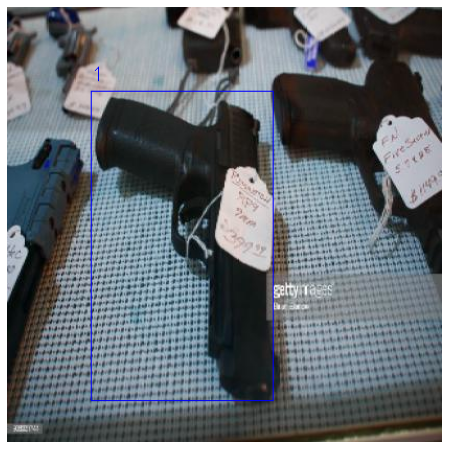

In [10]:
# Посмотрим на датасет
plot_ann_img('/content/drive/MyDrive/ISS_HACK/iss_hack_all-1/train/images/1--1-t_jpg.rf.8f9d3be4aa1033554956e95456fae39d.jpg',
             '/content/drive/MyDrive/ISS_HACK/iss_hack_all-1/train/labels/1--1-t_jpg.rf.8f9d3be4aa1033554956e95456fae39d.txt')

In [ ]:
!python train.py --img 416 --batch 4 --epochs 100 --data /content/drive/MyDrive/ISS_HACK/iss_hack_all-1/data.yaml --cfg /content/drive/MyDrive/ISS_HACK/yolov5/models/yolov5s.yaml --weights /content/drive/MyDrive/ISS_HACK/best_50_epoch_batch_4_gpu.pt # Нужно правильно прописать для тренировки на нашем датасете

wandb: Currently logged in as: egorv95 (use `wandb login --relogin` to force relogin)
train: weights=/content/drive/MyDrive/ISS_HACK/best_50_epoch_batch_4_gpu.pt, cfg=/content/drive/MyDrive/ISS_HACK/yolov5/models/yolov5s.yaml, data=/content/drive/MyDrive/ISS_HACK/iss_hack_all-1/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=4, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-206-gc43439a torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_

# Сохраняем веса

In [ ]:
!cp /content/drive/MyDrive/ISS_HACK/yolov5/runs/train/exp9/weights/best.pt /content/drive/MyDrive/ISS_HACK/best_150_epoch_batch_4_gpu.pt


# Возьмем 60 секунд из видео и протестируем сеть

In [ ]:
ffmpeg_extract_subclip("/content/drive/MyDrive/ISS_HACK/train/weapon_train.mp4", 0, 60, targetname="/content/drive/MyDrive/ISS_HACK/test_0_60.mp4")


[MoviePy] Running:
>>> /root/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1 -y -i /content/drive/MyDrive/ISS_HACK/train/weapon_train.mp4 -ss 0.00 -t 60.00 -vcodec copy -acodec copy /content/drive/MyDrive/ISS_HACK/test_0_60.mp4
... command successful.


In [ ]:
!python /content/drive/MyDrive/ISS_HACK/yolov5/detect.py --weights /content/drive/MyDrive/ISS_HACK/best_50_epoch_batch_4_gpu.pt --save-txt --save-conf --save-crop --source /content/drive/MyDrive/ISS_HACK/test_0_60.mp4

Выходные данные были обрезаны до нескольких последних строк (5000).
video 1/1 (1956/6952) /content/drive/MyDrive/ISS_HACK/test_0_60.mp4: 384x640 Done. (0.012s)
video 1/1 (1957/6952) /content/drive/MyDrive/ISS_HACK/test_0_60.mp4: 384x640 Done. (0.012s)
video 1/1 (1958/6952) /content/drive/MyDrive/ISS_HACK/test_0_60.mp4: 384x640 Done. (0.012s)
video 1/1 (1959/6952) /content/drive/MyDrive/ISS_HACK/test_0_60.mp4: 384x640 Done. (0.012s)
video 1/1 (1960/6952) /content/drive/MyDrive/ISS_HACK/test_0_60.mp4: 384x640 Done. (0.013s)
video 1/1 (1961/6952) /content/drive/MyDrive/ISS_HACK/test_0_60.mp4: 384x640 Done. (0.012s)
video 1/1 (1962/6952) /content/drive/MyDrive/ISS_HACK/test_0_60.mp4: 384x640 Done. (0.013s)
video 1/1 (1963/6952) /content/drive/MyDrive/ISS_HACK/test_0_60.mp4: 384x640 Done. (0.012s)
video 1/1 (1964/6952) /content/drive/MyDrive/ISS_HACK/test_0_60.mp4: 384x640 Done. (0.012s)
video 1/1 (1965/6952) /content/drive/MyDrive/ISS_HACK/test_0_60.mp4: 384x640 Done. (0.012s)
video 1/1 (1